In [1]:
! ls -l

total 132
-rw-rw-r-- 1 dabdya dabdya 58766 окт  7 13:46 Attention_affect.ipynb
-rw-rw-r-- 1 dabdya dabdya 35675 окт  7 12:37 pns10_res.json
-rw-rw-r-- 1 dabdya dabdya 35673 окт  7 12:36 pns20_res.json


In [46]:
import matplotlib.pyplot as plt
import pandas as pd
import json

from datetime import datetime as dt

In [80]:
with open("pns10_res.json", "r") as f:
    pns10 = json.load(f)
    
with open("pns20_res.json", "r") as f:
    pns20 = json.load(f)

### Воспроизведение результата

Обучил ```LSTM``` для размеров ```PNS``` = $[10, 20]$ на датасете ```big``` с параметрами:
* ```EC50``` количество эпох
* ```BS10K``` размер батча
* ```PCL25``` размер контекста
* ```PCLS``` = $[0, 0.15, 0.25, 0.5]$ доля правого контекста

Для параллельного обучения сеток с размерами $[5, 50]$ пока не хватило ресурсов, можно сделать последовательно позже. Обучение проходило в облаке на двух инстансах (для каждого ```PNS```) с ресурсами ```vCPU = 2```, ```RAM = 16GB``` и заняло:

In [77]:
mask = '%Y-%m-%d %H:%M:%S.%f'

def hours_for_training(pns):
    job_ids = list(pns.keys())
    
    return {
        job_id: (
            dt.strptime(pns[job_id][-1]['timestamp'], mask) - \
            dt.strptime(pns[job_id][0]['timestamp'], mask)
        ).total_seconds() / 3600
        for job_id in job_ids
    }

In [87]:
hours_for_training(pns10), f"sum_hours = {sum(hours_for_training(pns10).values())}"

({'TSAG-PNMLSTM-PNS10-EC50-BS10K-PCL25-PCLS0': 1.6489413227777776,
  'TSAG-PNMLSTM-PNS10-EC50-BS10K-PCL25-PCLS015': 1.812257686111111,
  'TSAG-PNMLSTM-PNS10-EC50-BS10K-PCL25-PCLS025': 1.863062795,
  'TSAG-PNMLSTM-PNS10-EC50-BS10K-PCL25-PCLS05': 2.026985008611111},
 'sum_hours = 7.3512468124999995')

In [88]:
hours_for_training(pns20), f"sum_hours = {sum(hours_for_training(pns20).values())}"

({'TSAG-PNMLSTM-PNS20-EC50-BS10K-PCL25-PCLS0': 1.5280549477777776,
  'TSAG-PNMLSTM-PNS20-EC50-BS10K-PCL25-PCLS015': 1.7085812044444444,
  'TSAG-PNMLSTM-PNS20-EC50-BS10K-PCL25-PCLS025': 1.7563427827777776,
  'TSAG-PNMLSTM-PNS20-EC50-BS10K-PCL25-PCLS05': 1.8646181483333335},
 'sum_hours = 6.857597083333333')

Размер контекста всегда одинаковый, но чем больше доля правого контекста тем больше времени уходит на обучение, и, чем больше размер сети, тем она быстрее заканчивает обучение. Контринтуитивные наблюдения, возможно, просто случайность.

In [31]:
def plot(pns, title):
    job_ids = list(pns.keys())
    fig, ax = plt.subplots(figsize=(8,4))

    for job_id in job_ids:
        df = pd.DataFrame(pns[job_id]).set_index('iteration')
        ax.plot(df.index, df.roc_auc_score_test, label=job_id)

    ax.set_title(title)
    ax.legend()

(None, None)

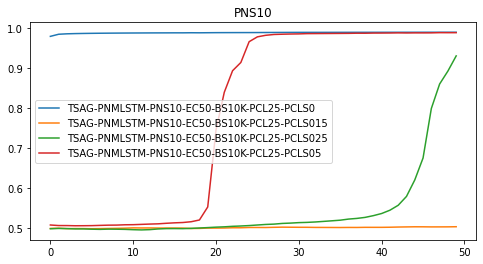

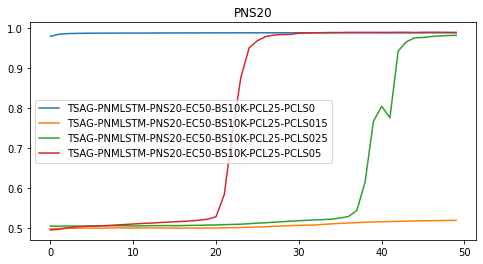

In [32]:
plot(pns10, "PNS10"), plot(pns20, "PNS20")

Наблюдаемые дефекты:

* Медленная сходимость при включении правого контекста, при этом отсутствует зависимость между ```PCLS``` и скоростью сходимости (чем больше правый контекст тем медленнее сходимость)

* Обучение в минус

Помимо этого модель с параметром ```PLS015``` за ```50``` эпох не сходится, но растет, наверно я взял какие-то другие параметы, но в целом похоже.

Обучение ставил на ночь, утром обычные лстмки закончили обучение, сетки с ```attention``` завершили примерно половину, т.е. обычные лстмки обучаются примерно в ```2``` раза быстрее, но гипотеза была про другое.

###  Помогает ли attention убрать дефекты при смещенном контексте?

Перевернутый контекст пока что не смотрел, по той же причине почему не смотрел ```PNS``` = $[5, 50]$. Для остального:

Обучение для ```attention``` продолжается в облаке прямо сейчас, из логов видно что дефекты пока не встречались, а сходимость начинается примерно в одно и то же время на раннем этапе, но пока обобщать не буду. Чуть позже здесь будут графики, время потраченное на обучение и еще надо как-то убедительно ответить на вопрос в заголовке.